# For DCD curves from raw magnetometer data

- (Note: This will only work for an DCD curve that goes down and to the left)
- upload your magnetometer results as a .csv file to the same folder that this Jupyter notebook is in
- this code will find the 'Magnetic Field (Oe)' and 'Moment (emu)' columns located in Columns D & E, row 35 of your file (Note: the data must be titled/located in this way, if you want to change the location or name of the data, further editing of this code is required)
- this code will also find the sample mass from the magnetometer data, and convert it to mg for normalization
- change the "adjustable parameters" section to your parameters or values
- Comment/uncomment the very last line of code to transfer the data to an excel spreadsheet

#### Adjustable parameters

In [1]:
input_file_name='FEPD_CA500C_1HR_1X1MMSQUARE_TRANS_DCD_08_06_24.csv'
input_directory_name = './recoilcurves_input' 
output_file_name = 'CA_DCD_Recoil_Curve_Analysis.xlsx' 
output_directory_name = './recoilcurves_output'

demag_factor=0.0163
density=9.9 #g/cm^3

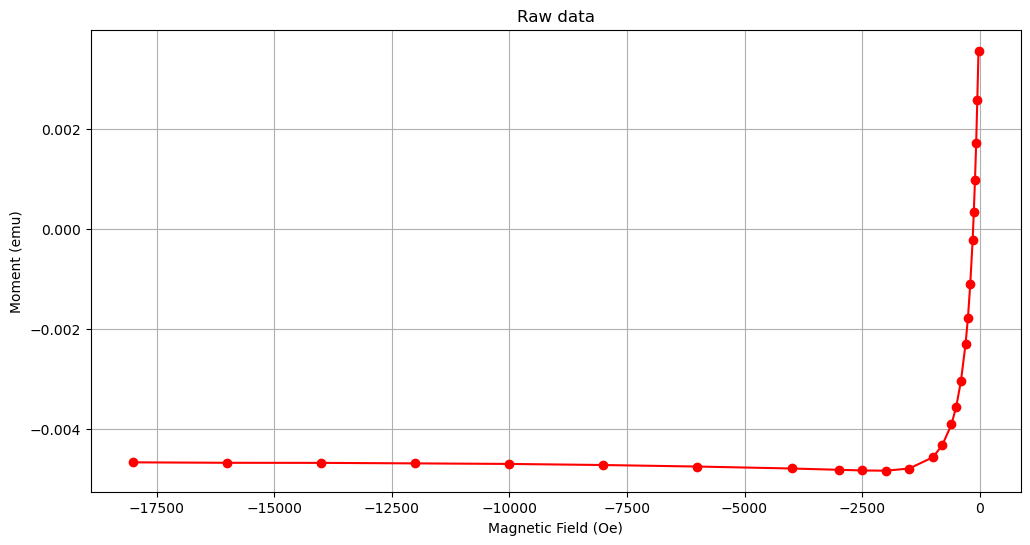

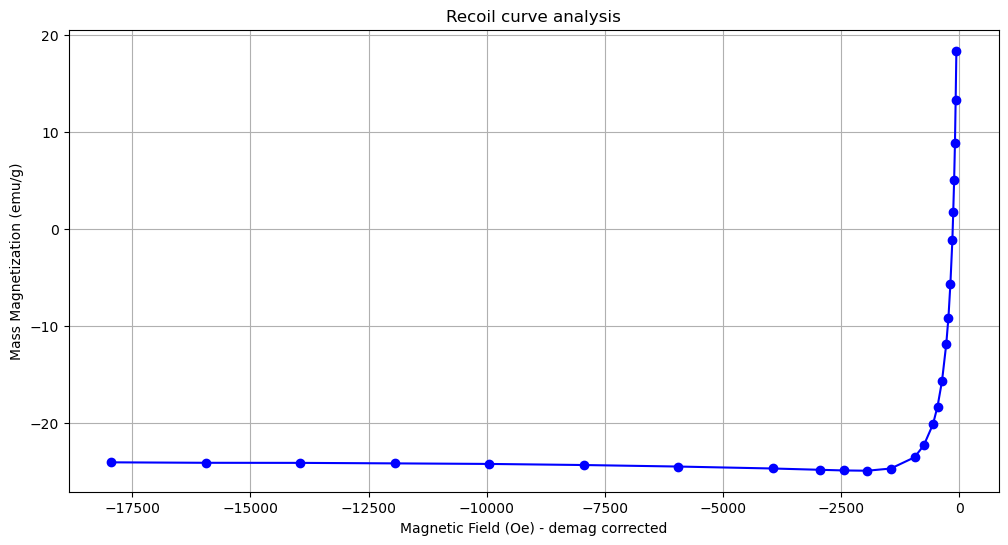

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

#Change file directory syntax for code
inname=input_file_name
indir=input_directory_name
outname=output_file_name
outdir=output_directory_name

#Find the input file  
if not os.path.exists(indir):  
    os.mkdir(indir)  
  
file_path = os.path.join(indir, inname)      

#Locate sample mass value
df1 = pd.read_csv(file_path)
sample_mass = df1.iloc[23, 1]  # Row 25, Column B (0-based index)
sample_mass_mg = float(sample_mass)/1000

df2 = pd.read_csv(file_path, skiprows=34)

# Extract x and y columns
x = df2['Magnetic Field (Oe)']  # Assumes there's a column named 'x'
y = df2['Moment (emu)']  # Assumes there's a column named 'y'

# Initialize xnew and ynew to store the counted values
xnew = []
ynew = []

# Variables to track the current trend
is_decreasing = True

# Iterate through x and y to find local maxima and minima
for i in range(1, len(x) - 1):
    if is_decreasing:
        # Check if it's a maximum
        if x[i] < x[i - 1] and x[i] < x[i + 1]:
            xnew.append(x[i])  # Append local max in x to xnew
            is_decreasing = False  # Switch to looking for a minimum
    else:
        # Check if it's a minimum
        if x[i] > x[i - 1] and x[i] > x[i + 1]:
            ynew.append(y[i])  # Append corresponding y for local min in x to ynew
            is_decreasing = True  # Switch to looking for a maximum

# Check if the last point in x is a maximum
#if is_increasing and x[-1] > x[-2]:  # Last point is a maximum
#    xnew.append(x[-1])
#else:
#    ynew.append(y[-1])  # Last point is a minimum

# Ensure xnew and ynew are of the same length
min_length = min(len(xnew), len(ynew))
xnew = xnew[:min_length]
ynew = ynew[:min_length]

# Normalize with sample mass
ynew_numeric = [float(yvalue) for yvalue in ynew]
y_normalized = [yvalue / sample_mass_mg for yvalue in ynew_numeric]

#Correct for demagnetization
x_numeric=[float(xvalue) for xvalue in xnew]
x_corrected = [xvalue - (4 * np.pi * demag_factor * yvalue * density) for xvalue, yvalue in zip(x_numeric, y_normalized)]

# Plot ynew vs xnew
plt.figure(figsize=(12,6))
plt.plot(xnew, ynew, marker='o', color='r', linestyle='-')
plt.xlabel('Magnetic Field (Oe)')
plt.ylabel('Moment (emu)')
plt.title('Raw data')
plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(x_corrected, y_normalized, marker='o', color='b', linestyle='-')
plt.xlabel('Magnetic Field (Oe) - demag corrected')
plt.ylabel('Mass Magnetization (emu/g)')
plt.title('Recoil curve analysis')
plt.grid()
plt.show()

# Export to a new Excel file
data = {'Magnetic Field (Oe)': xnew, 'Moment (emu)': ynew, 'Demag-Corrected Field (Oe)': x_corrected, 'Mass Magnetization (emu/g)': y_normalized }
df = pd.DataFrame(data)

if not os.path.exists(outdir):  
    os.mkdir(outdir)  
  
fullname = os.path.join(outdir, outname)      
  
df.to_excel(fullname)  